<a href="https://colab.research.google.com/github/kappandrew2/DataPreProcessing/blob/main/MarketResearch_v003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Model Purpose

Utilize historical value and time attributes to predict the next day's gain or loss value

!Dataset Notes: The dataset for this data solution must come from the following web sit and contain a large historical sample of data. For example:

Begin Date = 12/01/2007 (Be mindful that the last 35 periods (in this case, days) will get chopped off of the bottom of the dataset during data preprocessing)

End Date = Today's current value (to be run an hour before market close)

Ticker = SPY

Train Set = all data except last 60 periods (rows)

Prediction Set = all data from -90 periods (days) to current

https://www.wsj.com/market-data/quotes/index/SPX/historical-prices


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.model_selection import train_test_split
from datetime import date, datetime, timedelta
from pandas._libs.tslibs.timestamps import Timestamp
from scipy.sparse import csr_matrix


#Connect to drive and import data set

Using google drive

Importing historical prices for ticker "SPY"

In [ ]:
#Create CSV from data export
#https://www.wsj.com/market-data/quotes/index/SPX/historical-prices

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

dataset1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HistoricalPricesSPY.csv')

dataset2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HistoricalPricesSH.csv')

print(dataset1)

Mounted at /content/drive
          Date    Open      High     Low     Close     Volume
0     08/06/21  442.10  442.9400  441.80  442.4900   46930008
1     08/05/21  440.22  441.8500  439.88  441.7600   38969660
2     08/04/21  439.78  441.1243  438.73  438.9800   46732207
3     08/03/21  438.44  441.2800  436.10  441.1500   58053898
4     08/02/21  440.34  440.9300  437.21  437.5900   58783301
...        ...     ...       ...     ...       ...        ...
1404  01/08/16  195.19  195.8500  191.58  191.9230  209817203
1405  01/07/16  195.33  197.4400  193.59  194.0500  213436094
1406  01/06/16  198.34  200.0600  197.60  198.8200  152112609
1407  01/05/16  201.40  201.9000  200.05  201.3600  110845797
1408  01/04/16  200.49  201.0300  198.59  201.0192  222353500

[1409 rows x 6 columns]


#Modifiy dataset Content and Headers

Remove contents not required for this exercise

Renaming columns to remove leading white space

Narrowing the dataset can be done via drop or select, both options are available (comment out the one not in use)

In [ ]:
#Reduce dataframe columns
dataset1.rename({' Close': 'Close'}, axis=1, inplace = True)
dataset1 = dataset1[['Close', 'Date']]
#Reduce Dataframe columns
dataset2.rename({' Close': 'Close'}, axis=1, inplace = True)
dataset2 = dataset2[['Close', 'Date']]

#Set data types
dataset1['Date'] = pd.to_datetime(dataset1['Date'])
#Set data types
dataset2['Date'] = pd.to_datetime(dataset2['Date'])

#Create date attributes
dataset1['DOW'] = dataset1['Date'].dt.dayofweek
dataset1['Month'] = dataset1['Date'].dt.month
dataset1['Quarter'] = dataset1['Date'].dt.quarter
#Create date attributes
dataset2['DOW'] = dataset2['Date'].dt.dayofweek
dataset2['Month'] = dataset2['Date'].dt.month
dataset2['Quarter'] = dataset2['Date'].dt.quarter

#Date to sparse matrix
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(drop='first')
#Encode Time Variables
dow1 = ohe.fit_transform(dataset1.DOW.values.reshape(-1,1)).toarray()
DOW1 = pd.DataFrame(dow1, columns = ['Tu', 'We', 'Th', 'Fr'])
month1 = ohe.fit_transform(dataset1.Month.values.reshape(-1,1)).toarray()
MONTH1 = pd.DataFrame(month1, columns = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
q1 = ohe.fit_transform(dataset1.Quarter.values.reshape(-1,1)).toarray()
Q1 = pd.DataFrame(q1, columns = ['Q2', 'Q3', 'Q4'])
dataset1 = pd.concat([dataset1, DOW1, MONTH1, Q1], axis=1)
#Encode Time Variables
dow2 = ohe.fit_transform(dataset2.DOW.values.reshape(-1,1)).toarray()
DOW2 = pd.DataFrame(dow2, columns = ['Tu', 'We', 'Th', 'Fr'])
month2 = ohe.fit_transform(dataset2.Month.values.reshape(-1,1)).toarray()
MONTH2 = pd.DataFrame(month2, columns = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
q2 = ohe.fit_transform(dataset2.Quarter.values.reshape(-1,1)).toarray()
Q2 = pd.DataFrame(q2, columns = ['Q2', 'Q3', 'Q4'])
dataset2 = pd.concat([dataset2, DOW2, MONTH2, Q2], axis=1)

#Gain_loss_interval
dataset1['gain_loss_0'] = dataset1['Close'].diff(-1)
dataset1['gain_loss_1'] = dataset1['Close'].diff(-2)
dataset1['gain_loss_2'] = dataset1['Close'].diff(-3)
#Gain_loss_interval
dataset2['gain_loss_0'] = dataset2['Close'].diff(-1)
dataset2['gain_loss_1'] = dataset2['Close'].diff(-2)
dataset2['gain_loss_2'] = dataset2['Close'].diff(-3)

#Gain_loss_history
dataset1['prior_day_1'] = dataset1['gain_loss_0']
dataset1['prior_day_1'] = dataset1['prior_day_1'].shift(periods=-1, fill_value=0)
dataset1['prior_day_2'] = dataset1['gain_loss_0']
dataset1['prior_day_2'] = dataset1['prior_day_2'].shift(periods=-2, fill_value=0)
#Gain_loss_history
dataset2['prior_day_1'] = dataset2['gain_loss_0']
dataset2['prior_day_1'] = dataset2['prior_day_1'].shift(periods=-1, fill_value=0)
dataset2['prior_day_2'] = dataset2['gain_loss_0']
dataset2['prior_day_2'] = dataset2['prior_day_2'].shift(periods=-2, fill_value=0)

#Rolling means
rolling_prior_day1 = dataset1['gain_loss_0']
rolling_prior_day_5_1 = rolling_prior_day1[::-1].rolling(5).mean()[::-1]
rolling_prior_day_10_1 = rolling_prior_day1[::-1].rolling(10).mean()[::-1]
rolling_prior_day_5_1.rename('rolling_prior_day_5', inplace = True)
rolling_prior_day_10_1.rename('rolling_prior_day_10', inplace = True)
dataset = pd.concat([dataset1, rolling_prior_day_10_1, rolling_prior_day_10_1], axis = 1)
#Rolling means
rolling_prior_day2 = dataset2['gain_loss_0']
rolling_prior_day_5_2 = rolling_prior_day2[::-1].rolling(5).mean()[::-1]
rolling_prior_day_10_2 = rolling_prior_day2[::-1].rolling(10).mean()[::-1]
rolling_prior_day_5_2.rename('rolling_prior_day_5', inplace = True)
rolling_prior_day_10_2.rename('rolling_prior_day_10', inplace = True)
dataset = pd.concat([dataset2, rolling_prior_day_10_2, rolling_prior_day_10_2], axis = 1)

#Remove NaN rows
dataset1.dropna(inplace = True)
#Remove NaN rows
dataset2.dropna(inplace = True)

#add dependant variable (requires shifted down one row)
y1 = pd.DataFrame(dataset1['gain_loss_0']).reset_index(drop = True)
y1.loc[-1] = [0]
y1.index = y1.index + 1
y1 = y1.sort_index()
y1.drop(y1.tail(1).index, inplace = True)
y1.rename(columns={'gain_loss_0': 'y'}, inplace=True)
y_df1 = pd.DataFrame(y1, columns=['y'])
dataset_final1 = pd.concat([dataset1, y_df1], axis=1)
#add dependant variable (requires shifted down one row)
y2 = pd.DataFrame(dataset2['gain_loss_0']).reset_index(drop = True)
y2.loc[-1] = [0]
y2.index = y2.index + 1
y2 = y2.sort_index()
y2.drop(y2.tail(1).index, inplace = True)
y2.rename(columns={'gain_loss_0': 'y'}, inplace=True)
y_df2 = pd.DataFrame(y2, columns=['y'])
dataset_final2 = pd.concat([dataset2, y_df2], axis=1)

#drop NaN on final datase
dataset_final1.dropna(inplace = True)
#drop NaN on final datase
dataset_final2.dropna(inplace = True)

#add prefix to all columns
dataset_final1.columns = [str(col) + '_1' for col in dataset_final1.columns]
#add prefix to all columns
dataset_final2.columns = [str(col) + '_2' for col in dataset_final2.columns]

In [ ]:
#Concatenate the dataset
dataset_final = pd.concat([dataset_final1, dataset_final2], axis=1)

#Determine Attributes to Keep

In [ ]:
#identify columns for data model
selection_value_upper = .06
corr_mxa = dataset_final.corr()
corr_mxb = corr_mxa[corr_mxa['y_1'].abs()>selection_value]
corr_mxb = corr_mxb.T.columns.values
add_back = 'Date_1'
corr_mxb = np.concatenate((corr_mxb, add_back), axis=None)

In [ ]:
#add needed attributes back into the model
dataset_final = dataset_final[corr_mxb]
dataset_final['Date_1'] = pd.to_datetime(dataset_final['Date_1'])
dataset_final['Close_1'] = dataset_final1['Close_1']
dataset_final['Close_2'] = dataset_final2['Close_2']
print(dataset_final)

      DOW_1  Quarter_1  We_1  Mar_1  ...  prior_day_2_2   y_2     Date_1   Close_1
0         4          3   0.0    0.0  ...           0.07  0.00 2021-08-06  442.4900
1         3          3   0.0    0.0  ...          -0.13 -0.02 2021-08-05  441.7600
2         2          3   1.0    0.0  ...           0.04 -0.10 2021-08-04  438.9800
3         1          3   0.0    0.0  ...           0.07  0.07 2021-08-03  441.1500
4         0          3   0.0    0.0  ...          -0.07 -0.13 2021-08-02  437.5900
...     ...        ...   ...    ...  ...            ...   ...        ...       ...
1401      2          1   1.0    0.0  ...           0.00 -0.78 2016-01-13  188.8300
1402      1          1   0.0    0.0  ...           0.48  1.18 2016-01-12  193.6608
1403      0          1   0.0    0.0  ...           0.98 -0.44 2016-01-11  192.1100
1404      4          1   0.0    0.0  ...           0.60  0.00 2016-01-08  191.9230
1405      3          1   0.0    0.0  ...          -0.12  0.48 2016-01-07  194.0500

[14

#Create dataset splitting variable (Train and Pred)

Date variables based on today date are required to prevent "hardcoding" dates into the model

The date_var variable will represent the most current date in the dataset. This allows the solution to be run for any timeframe.

The following code can replace the current date_var logic in the case the current method causes issues. Note, this method requires adjustment when back testing 

date_var = pd.to_datetime(date.today()) 

use train/pred_minus_days to tune the model for longer or shorter periods of time. Allow for a 30 day overlap where pred will have 30 days

In [ ]:
train_minus_days = 180
pred_minus_days = 150

date_var = dataset_final['Date_1'].max()
train_begin_date = dataset_final['Date_1'].min()
train_end_date = (date_var - pd.to_timedelta(train_minus_days, unit='d'))
pred_begin_date = (date_var - pd.to_timedelta(pred_minus_days, unit='d'))
pred_end_date = date_var

train_begin_date = train_begin_date.to_pydatetime()
train_end_date = train_end_date.to_pydatetime()
pred_begin_date = pred_begin_date.to_pydatetime()
pred_end_date = pred_end_date.to_pydatetime()


print(train_begin_date)
print(train_end_date)
print(pred_begin_date)
print(pred_end_date)

2016-01-07 00:00:00
2021-02-07 00:00:00
2021-03-09 00:00:00
2021-08-06 00:00:00


#Split between training and predict data sets

The top last 90 periods (rows) will generate the pred data set.

All but the top 60 periods (rows) will generate the training data set.

The 30 day overlap can provide a measure of the model's degredation over time

!Note - The market is closed on weekends and holidays. The count of days in each set will NOT equal the amount of days between begin and end dates.

In [ ]:
#split text and train datasets
predset = dataset_final[(dataset_final['Date_1'] >= pred_begin_date) & 
                        (dataset_final['Date_1'] <= pred_end_date)]
trainset = dataset_final[(dataset_final['Date_1'] >= train_begin_date) & 
                         (dataset_final['Date_1'] <= train_end_date)]
type(predset)

pandas.core.frame.DataFrame

In [ ]:
list(dataset_final.columns)

['DOW_1',
 'Quarter_1',
 'We_1',
 'Mar_1',
 'Apr_1',
 'Jul_1',
 'Aug_1',
 'Sep_1',
 'Oct_1',
 'Nov_1',
 'Dec_1',
 'Q2_1',
 'gain_loss_0_1',
 'gain_loss_1_1',
 'gain_loss_2_1',
 'prior_day_1_1',
 'y_1',
 'Close_2',
 'DOW_2',
 'Quarter_2',
 'We_2',
 'Mar_2',
 'Apr_2',
 'Jul_2',
 'Aug_2',
 'Sep_2',
 'Oct_2',
 'Nov_2',
 'Dec_2',
 'Q2_2',
 'gain_loss_0_2',
 'gain_loss_1_2',
 'gain_loss_2_2',
 'prior_day_1_2',
 'prior_day_2_2',
 'y_2',
 'Date_1',
 'Close_1']

#Convert dataset into X and y and refine column membership

This process separates the dependant and independant variables

X should not contain the y or yb attributes

for X, "Date" should be removed since it is a time-series value; date attributes will represent time

for X, "Close" should be removed due to its relationship to the indepenant variable

Two models will come out of this model, one for continuous variable y and binary value yb

In [ ]:
XX = trainset
XX.drop(XX.tail(31).index, inplace = True)
X = XX.drop(['y_1', 'y_2', 'Date_1', 'Close_1', 'Close_2'], axis=1)
y_1 = trainset['y_1'].values
y_2 = trainset['y_2'].values
print(X)
print("-------------------------")
print(y_1)
print("-------------------------")
print(y_2)

      DOW_1  Quarter_1  We_1  ...  gain_loss_2_2  prior_day_1_2  prior_day_2_2
126       4          1   0.0  ...          -0.30          -0.20          -0.02
127       3          1   0.0  ...          -0.47          -0.02          -0.25
128       2          1   1.0  ...          -0.55          -0.25          -0.28
129       1          1   0.0  ...          -0.19          -0.28           0.34
130       0          1   0.0  ...          -0.08           0.34          -0.14
...     ...        ...   ...  ...            ...            ...            ...
1370      0          1   0.0  ...          -0.06           0.10          -0.56
1371      4          1   0.0  ...          -0.68          -0.56          -0.22
1372      3          1   0.0  ...          -0.18          -0.22           0.60
1373      2          1   1.0  ...          -0.34           0.60          -0.72
1374      1          1   0.0  ...          -0.06          -0.72           0.06

[1249 rows x 33 columns]
-------------------------


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
#Validation of row counts

f = len(X)
g = len(y_1)
h = len(y_2)

print(f, g, h)

1249 1249 1249


#Train the models

The model can be extended to use any regression or classificaiton model.

Current model inventory:

1) Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators = 10, random_state = 2)

regressor.fit(X, y_1)

regressor_b = RandomForestRegressor(n_estimators = 10, random_state = 1)

regressor_b.fit(X, y_2)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

#Create predict dataset

The predict dataset should match the process used to generate the training dataset

In [ ]:
#Prepare predict set
Xpred = predset
X_pred = Xpred.drop(['y_1', 'y_2', 'Date_1', 'Close_1', 'Close_2'], axis=1)
y_actual = predset['y_1'].values
yb_actual = predset['y_2'].values
print(X_pred)
print("-------------------------")
print(y_actual)
print("-------------------------")
print(yb_actual)

     DOW_1  Quarter_1  We_1  ...  gain_loss_2_2  prior_day_1_2  prior_day_2_2
0        4          3   0.0  ...          -0.05          -0.10           0.07
1        3          3   0.0  ...          -0.16           0.07          -0.13
2        2          3   1.0  ...          -0.02          -0.13           0.04
3        1          3   0.0  ...          -0.02           0.04           0.07
4        0          3   0.0  ...           0.04           0.07          -0.07
..     ...        ...   ...  ...            ...            ...            ...
101      0          1   0.0  ...          -0.32          -0.04          -0.18
102      4          1   0.0  ...          -0.31          -0.18          -0.09
103      3          1   0.0  ...          -0.51          -0.09          -0.24
104      2          1   1.0  ...          -0.25          -0.24           0.08
105      1          1   0.0  ...          -0.49           0.08          -0.33

[106 rows x 33 columns]
-------------------------
[ 0.    0.73 

In [ ]:
i = len(Xpred)
j = len(y_actual)
k = len(yb_actual)

print(i, j, k)

106 106 106


#Generate predictions

Predictions are made for both continuous and binary

In [ ]:
y_1_pred = regressor.predict(X_pred)

y_2_pred = regressor_b.predict(X_pred)

#y_all_pred = regressor_all.predict(X_all_pred)

#y_all_pred_b = regressor_all_b.predict(X_all_pred)

np_array = np.concatenate((y_1_pred.reshape(len(y_1_pred),1), 
                           y_2_pred.reshape(len(y_2_pred),1),
                           y_actual.reshape(len(y_actual),1),
                           yb_actual.reshape(len(yb_actual),1),
                           ), axis = 1)

results = pd.DataFrame(np_array, columns = ['y_1_pred', 'y_2_pred', 'y_1_actual', 'y_2_actual'])

#########################need to shift y values up by one


sp500_pred = results.head(5)

print(results)


     y_1_pred  y_2_pred  y_1_actual  y_2_actual
0    -0.17100    -0.074        0.00        0.00
1     0.24000    -0.067        0.73       -0.02
2     1.56900    -0.010        2.78       -0.10
3    -0.87600     0.041       -2.17        0.07
4     1.14100    -0.095        3.56       -0.13
..        ...       ...         ...         ...
101  -1.63000     0.060       -0.50        0.02
102   1.64700    -0.049        2.35       -0.10
103   0.93100    -0.140        0.53       -0.04
104  -0.10808    -0.043        3.95       -0.18
105  -0.80800     0.031        2.41       -0.09

[106 rows x 4 columns]


#Create buy/sell indicator/strategy based on pred

0 = Buy nothing

1 = Buy market

2 = Buy market short



In [ ]:
results['y_gain_pred_arg'] = np.where((np.where(results['y_1_pred'] > 0, 1, 0) + np.where(results['y_2_pred'] > 0, 1, 0)) > 0, 1, 0)
results['purchase'] = np.where(results['y_gain_pred_arg'] > 0, np.where(results['y_1_pred'] > results['y_2_pred'], 1, 2), 0)
results['Close_1'] = Xpred['Close_1']
results['Close_2'] = Xpred['Close_2']
results['market'] = results['y_1_actual']/results['Close_1']
results['purchase_gain_loss'] = np.where(results['purchase'] == 1, #Change these between 1, 2 and 0 to alter the model behavior
                                         results['y_1_actual']/results['Close_1'], 
                                         np.where(results['purchase'] == 2, #Change these between 1, 2 and 0 to alter the model behavior
                                                  results['y_2_actual']/results['Close_2'], 0)) #Change these between 1, 2 and 0 to alter the model behavior
results['market_cumu'] = results.market[::-1].cumsum()
results['purchase_gain_loss_cumu'] = results.purchase_gain_loss[::-1].cumsum()

results

,y_1_pred,y_2_pred,y_1_actual,y_2_actual,y_gain_pred_arg,purchase,Close_1,Close_2,market,purchase_gain_loss,market_cumu,purchase_gain_loss_cumu
0,-0.17100,-0.074,0.00,0.00,0,0,442.49,14.86,0.000000,0.000000,0.136208,0.084649
1,0.24000,-0.067,0.73,-0.02,1,1,441.76,14.88,0.001652,0.001652,0.136208,0.084649
2,1.56900,-0.010,2.78,-0.10,1,1,438.98,14.98,0.006333,0.006333,0.134556,0.082997
3,-0.87600,0.041,-2.17,0.07,1,2,441.15,14.91,-0.004919,0.004695,0.128223,0.076664
4,1.14100,-0.095,3.56,-0.13,1,1,437.59,15.04,0.008135,0.008135,0.133142,0.071969
...,...,...,...,...,...,...,...,...,...,...,...,...
101,-1.63000,0.060,-0.50,0.02,1,2,396.41,16.83,-0.001261,0.001188,0.022413,0.003278
102,1.64700,-0.049,2.35,-0.10,1,1,394.06,16.93,0.005964,0.005964,0.023674,0.002090
103,0.93100,-0.140,0.53,-0.04,1,1,393.53,16.97,0.001347,0.001347,0.017711,-0.003874
104,-0.10808,-0.043,3.95,-0.18,0,0,389.58,17.15,0.010139,0.000000,0.016364,-0.005220


In [ ]:
results['market_cumu'] = results.market[::-1].cumsum()
results['purchase_gain_loss_cumu'] = results.purchase_gain_loss[::-1].cumsum()

In [ ]:
results

,y_1_pred,y_2_pred,y_1_actual,y_2_actual,y_gain_pred_arg,purchase,Close_1,Close_2,market,purchase_gain_loss,market_cumu,purchase_gain_loss_cumu
0,-0.17100,-0.074,0.00,0.00,0,0,442.49,14.86,0.000000,0.000000,0.136208,0.084649
1,0.24000,-0.067,0.73,-0.02,1,1,441.76,14.88,0.001652,0.001652,0.136208,0.084649
2,1.56900,-0.010,2.78,-0.10,1,1,438.98,14.98,0.006333,0.006333,0.134556,0.082997
3,-0.87600,0.041,-2.17,0.07,1,2,441.15,14.91,-0.004919,0.004695,0.128223,0.076664
4,1.14100,-0.095,3.56,-0.13,1,1,437.59,15.04,0.008135,0.008135,0.133142,0.071969
...,...,...,...,...,...,...,...,...,...,...,...,...
101,-1.63000,0.060,-0.50,0.02,1,2,396.41,16.83,-0.001261,0.001188,0.022413,0.003278
102,1.64700,-0.049,2.35,-0.10,1,1,394.06,16.93,0.005964,0.005964,0.023674,0.002090
103,0.93100,-0.140,0.53,-0.04,1,1,393.53,16.97,0.001347,0.001347,0.017711,-0.003874
104,-0.10808,-0.043,3.95,-0.18,0,0,389.58,17.15,0.010139,0.000000,0.016364,-0.005220


The following section should be turned into a loop

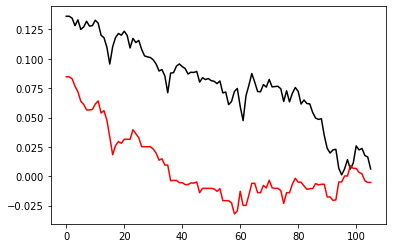

In [ ]:
plt.plot(results['market_cumu'], color='black')
plt.plot(results['purchase_gain_loss_cumu'], color='red')


In [ ]:
#results.to_csv('/content/drive/MyDrive/Colab Notebooks/results_sky_hibs_20160101-20210803_.csv')
#performance.to_csv('/content/drive/MyDrive/Colab Notebooks/performance_sky_hibs_20190101-20210803_.csv')